<a href="https://colab.research.google.com/github/kelly0924xu/Advanced-Data-Analysis/blob/master/ratio_alphafold_protein_properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from matplotlib.patches import Patch
from scipy.stats import mannwhitneyu

# Load them back
df_collapsed = pd.read_csv("df_collapsed.csv")
df_NMD_unique = pd.read_csv("df_NMD_unique.csv")

In [3]:
def add_property_level_metrics(
    df,
    aa_ctx="nmd",         # suffix in your per-AA columns, e.g. "nmd"
    prop_ctx="NMD",       # suffix for new property-level cols, e.g. "NMD"
    epsilon=1e-6,
    overwrite=False,
    groups=None
):
    # Default AA → property mapping
    if groups is None:
        groups = {
            "Nonpolar_Aliphatic": ["A","V","L","I","M"],
            "Aromatic":           ["F","W","Y"],
            "Polar_Uncharged":    ["S","T","N","Q","C"],
            "Positively_Charged": ["K","R","H"],
            "Negatively_Charged": ["D","E"],
            "Special_Cases":      ["G","P"],
        }

    def _safe_sum(cols):
        present = [c for c in cols if c in df.columns]
        if not present:
            return pd.Series(np.nan, index=df.index)
        return df[present].sum(axis=1)

    for prop, aa_list in groups.items():
        wt_cols  = [f"aa_AA_{a}_WT_{aa_ctx}"   for a in aa_list]
        var_cols = [f"aa_AA_{a}_vars_{aa_ctx}" for a in aa_list]

        wt_out   = f"{prop}_WT_{prop_ctx}"
        var_out  = f"{prop}_Var_{prop_ctx}"
        diff_out = f"{prop}_Diff_{prop_ctx}"
        ratio_out= f"{prop}_ratio_{aa_ctx}"
        l2fc_out = f"{prop}_log2FC_{prop_ctx}"

        if (not overwrite) and all(c in df.columns for c in [wt_out,var_out,diff_out,ratio_out,l2fc_out]):
            continue

        WT  = _safe_sum(wt_cols)
        VAR = _safe_sum(var_cols)

        df[wt_out]   = WT
        df[var_out]  = VAR
        df[diff_out] = VAR - WT
        df[ratio_out]= (VAR + epsilon) / (WT + epsilon)
        df[l2fc_out] = np.log2(df[ratio_out])

    return df

In [4]:
df_NMD_unique = add_property_level_metrics(
    df_NMD_unique,
    aa_ctx="nmd",   # matches per-AA col suffix
    prop_ctx="NMD", # naming convention for new property cols
    overwrite=True
)

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

FAMILY_COLOR = {'Minus1':'#4472C4', 'Plus1':'#C65911', 'Nonsense':'#70AD47'}

def lighten_color(color, amount=0.55):
    r, g, b = mcolors.to_rgb(color)
    return (1 - amount) + amount*r, (1 - amount) + amount*g, (1 - amount) + amount*b


def _resolve_prop_cols(df, props, metric="diff", context="NMD"):
    """
    props can be either full column names or base names like 'Aromatic'.
    We resolve to columns based on metric/context:
      - diff   -> '{prop}_Diff_{ctx}'
      - log2fc -> '{prop}_log2FC_{ctx}'
    """
    ctx = "NMD" if "NMD" in context.upper() else "FL"
    suffix = "Diff" if metric.lower() == "diff" else "log2FC"

    cols = []
    for p in props:
        if p in df.columns:
            cols.append(p)  # already a full column name
            continue
        cand = f"{p}_{suffix}_{ctx}"
        if cand in df.columns:
            cols.append(cand)
        else:
            # try to find a close match like 'Aromatic_Diff_NMD'
            regex = re.compile(rf"^{re.escape(p)}_(Diff|log2FC)_{ctx}$", re.IGNORECASE)
            match = [c for c in df.columns if regex.match(c)]
            if match:
                cols.append(match[0])
    return [c for c in cols if c in df.columns]

def plot_properties_one_panel(
    df,
    prop_cols,                   # list like ["Aromatic", "Nonpolar_Aliphatic", ...] OR full col names
    category="Minus1",           # "Minus1" | "Plus1" | "Nonsense"
    context_label="NMD region",  # or "Full length"
    savepath=None,
    order_props=None,
    metric="diff",               # "diff" or "log2fc"
    clip_quantiles=None,          # e.g., (0.01, 0.99) to winsorize per-property
    inset=None
):
    # --- pick columns for the requested metric ---
    use_cols = _resolve_prop_cols(df, prop_cols, metric=metric,
                                  context="NMD" if "NMD" in context_label.upper() else "FL")
    if not use_cols:
        print("No matching columns found for the requested metric/props.")
        return None, None

    long = df[use_cols + ["source"]].copy()

    # map source → group & family
    g = long["source"].astype(str)
    g = (g.str.replace("snv_control","Nonsense_Control",case=False,regex=False)
           .str.replace("snv","Nonsense",case=False,regex=False)
           .str.replace("minus1_control","Minus1_Control",case=False,regex=False)
           .str.replace("plus1_control","Plus1_Control",case=False,regex=False)
           .str.replace("minus1","Minus1",case=False,regex=False)
           .str.replace("plus1","Plus1",case=False,regex=False))
    long["group"]  = g
    long["family"] = long["group"].str.replace("_Control","",regex=False)
    long["status"] = np.where(long["group"].str.endswith("_Control"), "Control", "Candidate")

    # keep the chosen family
    long = long[long["family"] == category]
    if long.empty:
        print(f"No rows for category={category}.")
        return None, None

    # melt
    melted = long.melt(id_vars=["group","family","status","source"],
                       var_name="prop_col", value_name="value")

    # tidy property names
    melted["property"] = (melted["prop_col"]
                          .str.replace("_Diff_NMD","",regex=False)
                          .str.replace("_Diff_FL","", regex=False)
                          .str.replace("_log2FC_NMD","",regex=False)
                          .str.replace("_log2FC_FL","", regex=False)
                          .str.replace("_"," "))
    melted["value"] = pd.to_numeric(melted["value"], errors="coerce")

    # optional winsorizing per property (to shrink y-range without dropping points)
    if clip_quantiles is not None:
        qlo, qhi = clip_quantiles
        melted["value"] = (melted.groupby("property")["value"]
                           .transform(lambda s: s.clip(s.quantile(qlo), s.quantile(qhi))))

    # drop all-NaN properties
    good_props = melted.groupby("property")["value"].apply(lambda s: s.notna().any())
    melted = melted[melted["property"].isin(good_props[good_props].index)]

    if order_props is None:
        order_props = sorted(melted["property"].unique(), key=lambda s: s.lower())

    # --- plotting ---
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.grid(True, axis="y", alpha=0.3, linestyle="--"); ax.set_axisbelow(True)

    base = FAMILY_COLOR.get(category, "#777")
    pal = {"Candidate": base, "Control": lighten_color(base)}

    sns.boxplot(
        data=melted, x="property", y="value",
        hue="status", hue_order=["Candidate","Control"],
        order=order_props, palette=pal, width=0.65, dodge=True, ax=ax, legend=False
    )

    # stats (Mann–Whitney)
    y_max = float(np.nanmax(melted["value"]))
    rng = y_max - float(np.nanmin(melted["value"]))
    pad = 0.12 * (rng if rng > 0 else 1.0)
    y_annot = y_max + pad

    def stars(p): return "ns" if p>=0.05 else ("*" if p<0.05 and p>=0.01 else ("**" if p<0.01 and p>=0.001 else "***"))

    for i, prop in enumerate(order_props):
        sub = melted[melted["property"] == prop]
        a = sub.loc[sub["status"]=="Candidate","value"].dropna().to_numpy()
        b = sub.loc[sub["status"]=="Control","value"].dropna().to_numpy()
        if a.size and b.size:
            p = mannwhitneyu(a, b, alternative="two-sided").pvalue
            ax.text(i, y_annot, f"{stars(p)}\n"
                                f"n={a.size}/{b.size}\n"
                                f"p={p:.3g}",
                    ha="center", va="bottom",
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.6"),
                    fontsize=10)

    # y label / baseline
    if metric.lower() == "log2fc":
        ax.axhline(0, ls="--", lw=1, color="0.3")
        ylab = "log₂ fold-change (Var / WT)"
        title_metric = "log₂(Var/WT)"
    else:
        ylab = "Δ AA composition (Var − WT, %)"
        title_metric = "Var − WT"

    # ----- optional zoom inset -----
    if inset:
        # where/size of inset
        width     = inset.get("width", "36%")
        height    = inset.get("height","36%")
        loc       = inset.get("loc", "upper right")
        borderpad = inset.get("borderpad", 0.8)

        axins = inset_axes(ax, width=width, height=height, loc=loc, borderpad=borderpad)

        # re-plot the same boxes inside the inset (no legend)
        sns.boxplot(
            data=melted, x="property", y="value",
            hue="status", hue_order=["Candidate","Control"],
            order=order_props, palette=pal, width=0.65, dodge=True,
            ax=axins, legend=False
        )

        # choose inset y-limits
        if "limits" in inset:
            ylo, yhi = inset["limits"]
        elif "q" in inset:                       # e.g., q=(0.25, 0.75)
            qlo, qhi = melted["value"].quantile(inset["q"])
            pad = inset.get("pad", 0.5)          # add small margin
            ylo, yhi = qlo - pad, qhi + pad
        else:                                    # default: centered tight around 0
            r = inset.get("range", 2.0)          # total range (log2 units)
            ylo, yhi = -r/2, r/2

        axins.set_ylim(ylo, yhi)
        axins.axhline(0, ls="--", lw=1, color="0.3", zorder=0)

        # de-clutter inset
        axins.set_title("Zoom", fontsize=9, pad=2)
        axins.set_xlabel(""); axins.set_ylabel("")
        plt.setp(axins.get_xticklabels(), rotation=30, ha="right", fontsize=8)
        plt.setp(axins.get_yticklabels(), fontsize=8)

    # headroom for annotation
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax + 5)

    ax.set_xlabel("Physicochemical Property", fontsize=12, fontweight="bold")
    ax.set_ylabel(ylab, fontsize=12, fontweight="bold")
    ax.set_title(f"{category}: AA Properties — Candidate vs Control ({context_label}) [{title_metric}]",
                 fontsize=14, fontweight="bold", pad=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

    handles = [Patch(facecolor=pal["Candidate"], edgecolor="k", label="Candidate"),
               Patch(facecolor=pal["Control"],   edgecolor="k", label="Control")]
    ax.legend(handles=handles, title="Group", loc="upper left", bbox_to_anchor=(1.01, 1.0))

    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    return fig, ax


In [6]:
props_nmd = [
    "Aromatic",
    "Nonpolar_Aliphatic",
    "Polar_Uncharged",
    "Positively_Charged",
    "Negatively_Charged",
    "Special_Cases"
]

In [7]:
def add_property_level_metrics_fillna(
    df,
    aa_ctx="nmd",          # per-AA suffix: "nmd" or "fl"
    prop_ctx="NMD",        # property suffix for outputs: "NMD" or "FL"
    epsilon_pp=0.1,        # absolute floor in percentage points
    smooth_alpha=0.02,     # proportional smoothing as fraction of WT (e.g., 0.02 = 2%)
    overwrite=True,
    groups=None
):
    """
    Build property-level WT/Var totals, Diff, Ratio, and log2FC from per-AA *percent* composition.
    NaN values are treated as 0 (AA absent).

    Creates for each property P:
        P_WT_<prop_ctx>
        P_Var_<prop_ctx>
        P_Diff_<prop_ctx>          = Var - WT
        P_ratio_<aa_ctx>           = (Var + α*WT + ε_pp) / (WT + α*WT + ε_pp)
        P_log2FC_<prop_ctx>        = log2(P_ratio_<aa_ctx>)
    """
    if groups is None:
        groups = {
            "Nonpolar_Aliphatic": ["A","V","L","I","M"],
            "Aromatic":           ["F","W","Y"],
            "Polar_Uncharged":    ["S","T","N","Q","C"],
            "Positively_Charged": ["K","R","H"],
            "Negatively_Charged": ["D","E"],
            "Special_Cases":      ["G","P"],
        }

    for prop, aa_list in groups.items():
        wt_cols  = [f"aa_AA_{a}_WT_{aa_ctx}"   for a in aa_list]
        var_cols = [f"aa_AA_{a}_vars_{aa_ctx}" for a in aa_list]

        wt_out   = f"{prop}_WT_{prop_ctx}"
        var_out  = f"{prop}_Var_{prop_ctx}"
        diff_out = f"{prop}_Diff_{prop_ctx}"
        ratio_out= f"{prop}_ratio_{aa_ctx}"
        l2fc_out = f"{prop}_log2FC_{prop_ctx}"

        if (not overwrite) and all(c in df.columns for c in [wt_out,var_out,diff_out,ratio_out,l2fc_out]):
            continue

        # Fill NaNs with 0 before summing (absence = 0%)
        WT  = df[wt_cols].fillna(0).sum(axis=1).astype(float)
        VAR = df[var_cols].fillna(0).sum(axis=1).astype(float)

        # Store raw WT/Var and Diff
        df[wt_out]   = WT
        df[var_out]  = VAR
        df[diff_out] = VAR - WT

        # Percent-aware smoothing for ratios
        WT_s  = WT  + smooth_alpha*WT  + epsilon_pp
        VAR_s = VAR + smooth_alpha*WT  + epsilon_pp

        df[ratio_out] = VAR_s / WT_s
        df[l2fc_out]  = np.log2(df[ratio_out])

    return df

In [8]:
df_NMD_unique = add_property_level_metrics_fillna(
    df_NMD_unique.copy(),
    aa_ctx="nmd", prop_ctx="NMD",
    epsilon_pp=0.1,     # 0.1 percentage point floor
    smooth_alpha=0.02,  # 2% WT-proportional smoothing
    overwrite=True
)

/tmp/ipython-input-1082759960.py:189: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
/tmp/ipython-input-1082759960.py:189: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
/tmp/ipython-input-1082759960.py:189: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


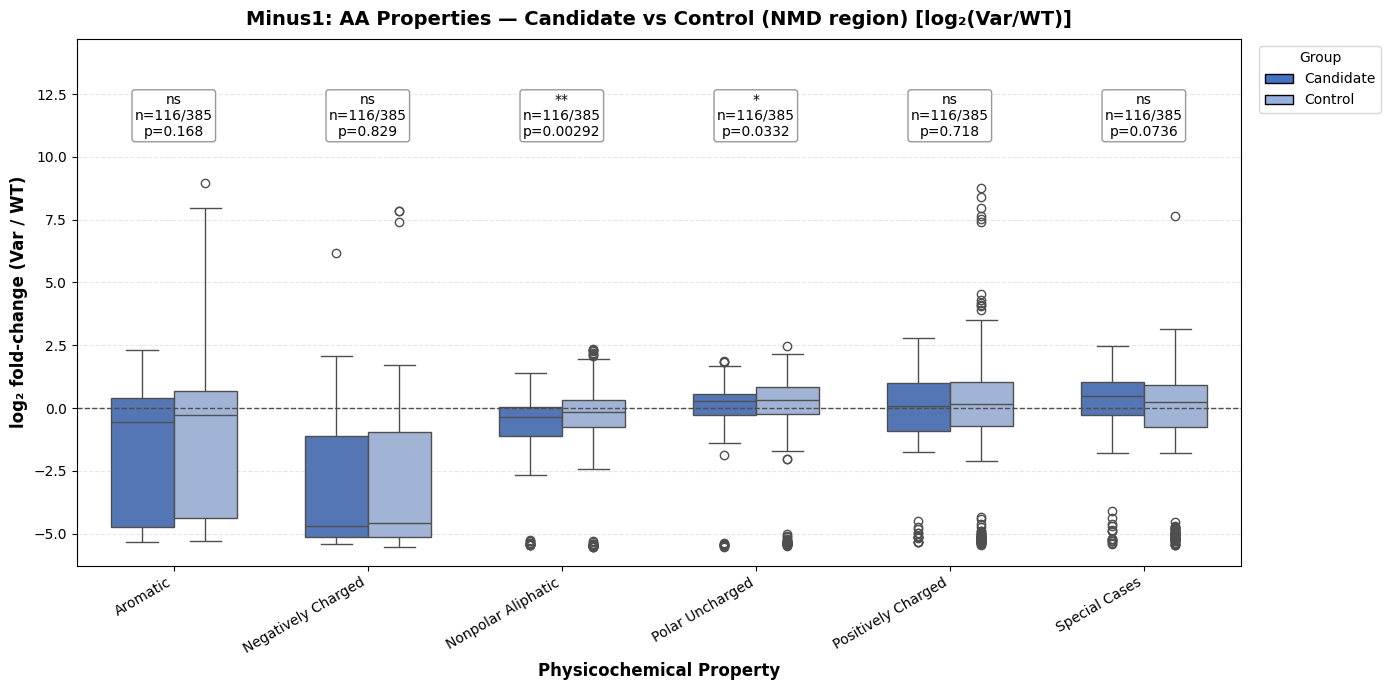

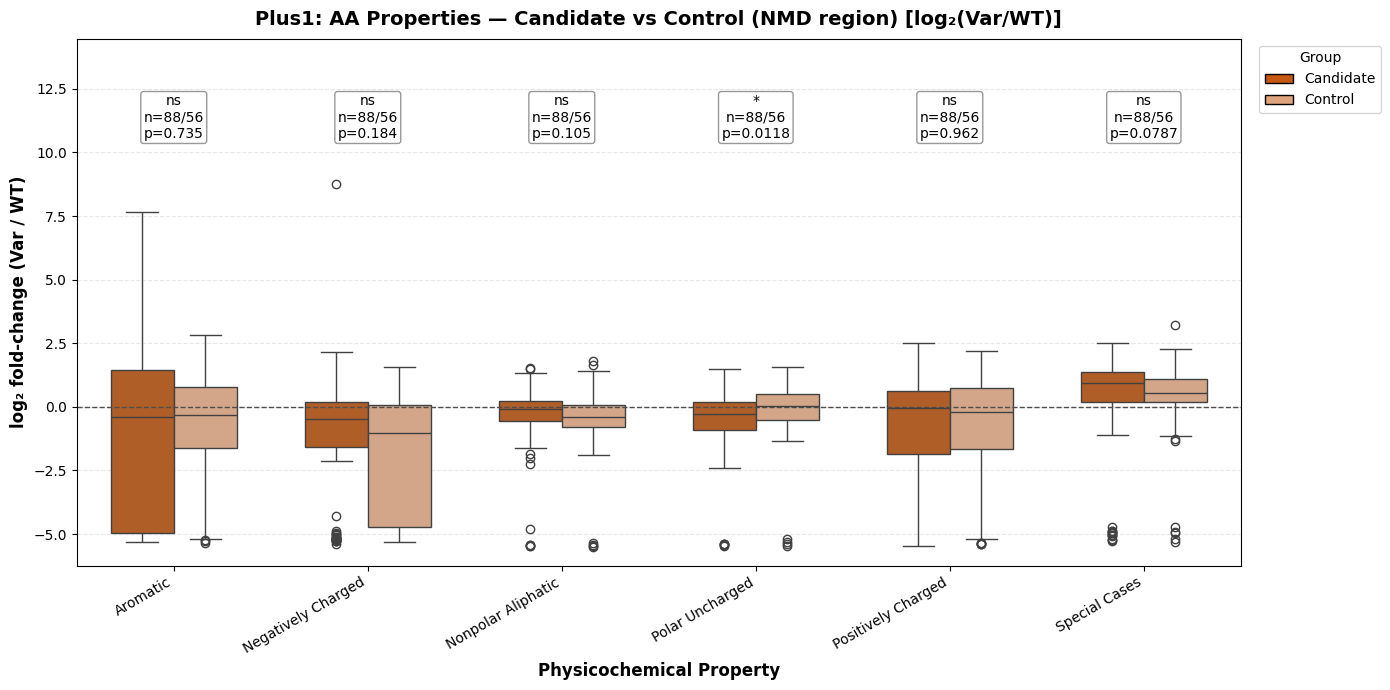

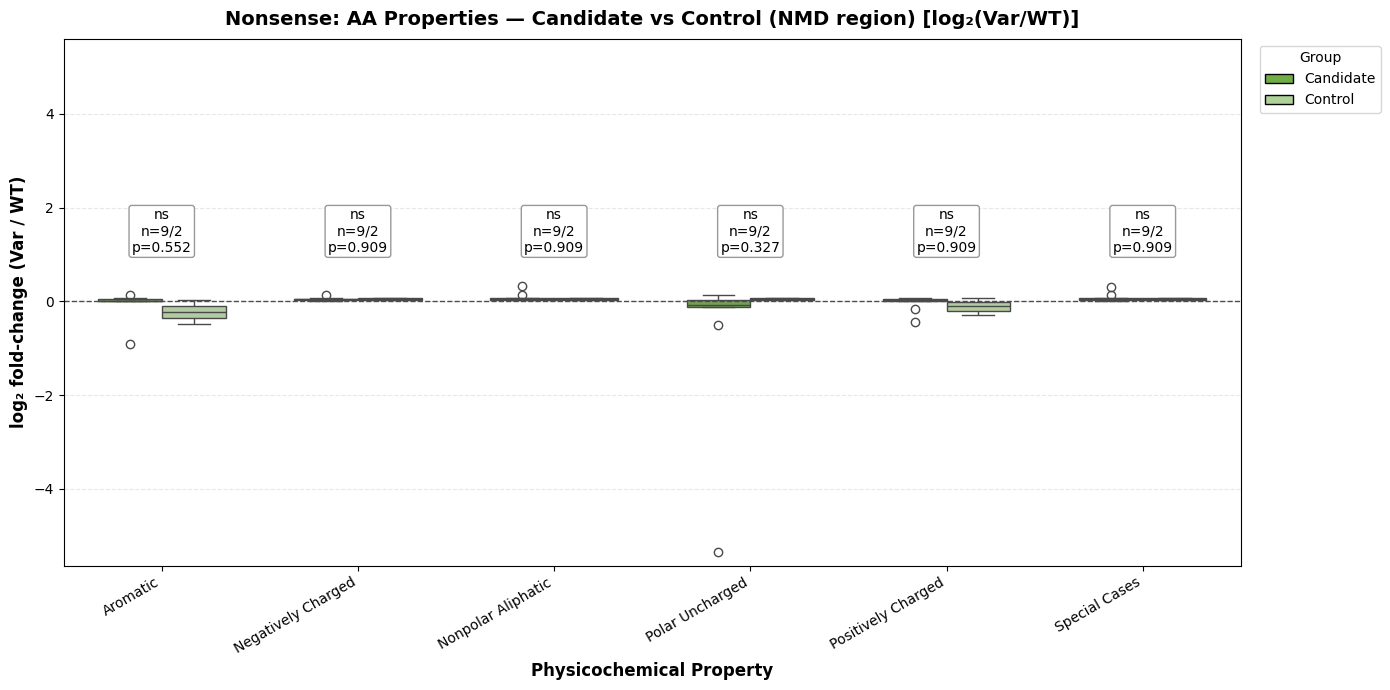

In [9]:
# Example: Minus1, full scale
plot_properties_one_panel(
    df_NMD_unique, props_nmd,
    category="Minus1", context_label="NMD region",
    metric="log2fc", savepath="Minus1_props_log2fc_raw.png"
)

# Do the same for Plus1 and Nonsense
for cat in ["Plus1","Nonsense"]:
    plot_properties_one_panel(
        df_NMD_unique, props_nmd,
        category=cat, context_label="NMD region",
        metric="log2fc", savepath=f"{cat}_props_log2fc_raw.png"
    )


In [10]:
props_nmd = [
    "Aromatic_log2FC_NMD","Negatively_Charged_log2FC_NMD",
    "Nonpolar_Aliphatic_log2FC_NMD","Polar_Uncharged_log2FC_NMD",
    "Positively_Charged_log2FC_NMD","Special_Cases_log2FC_NMD"
]

In [11]:
def plot_properties_central(
    df,
    prop_cols,                   # e.g. ["Aromatic_log2FC_NMD", ...] or *_Diff_*
    category="Minus1",
    context_label=None,          # Auto-detect from column names if None
    metric="log2fc",             # "log2fc" or "diff" (y-label & baseline)
    q=(0.05, 0.95),              # central quantile window to display (changed default)
    pad=0.15,                    # extra headroom around that window (reduced default)
    stats_headroom=0.15,         # additional space above data for stats boxes
    hide_fliers=True,            # hide outlier markers for a cleaner look
    clip_whiskers=True,          # clip whiskers/outliers outside ylim
    savepath=None,
):
    # ----- tidy to long form -----
    long = df[prop_cols + ["source"]].copy()

    g = long["source"].astype(str)
    g = (g.str.replace("snv_control","Nonsense_Control",case=False,regex=False)
           .str.replace("snv","Nonsense",case=False,regex=False)
           .str.replace("minus1_control","Minus1_Control",case=False,regex=False)
           .str.replace("plus1_control","Plus1_Control",case=False,regex=False)
           .str.replace("minus1","Minus1",case=False,regex=False)
           .str.replace("plus1","Plus1",case=False,regex=False))
    long["group"]  = g
    long["family"] = long["group"].str.replace("_Control","",regex=False)
    long["status"] = np.where(long["group"].str.endswith("_Control"), "Control", "Candidate")

    long = long[long["family"] == category]
    if long.empty:
        raise ValueError(f"No rows for category={category}")

    melted = long.melt(id_vars=["group","family","status","source"],
                       var_name="prop_col", value_name="value")

    # pretty property names
    melted["property"] = (melted["prop_col"]
                          .str.replace("_Diff_NMD","",regex=False)
                          .str.replace("_Diff_FL","",regex=False)
                          .str.replace("_log2FC_NMD","",regex=False)
                          .str.replace("_log2FC_FL","",regex=False)
                          .str.replace("_", " "))
    melted["value"] = pd.to_numeric(melted["value"], errors="coerce")

    # drop properties that are entirely NaN
    good_props = melted.groupby("property")["value"].apply(lambda s: s.notna().any())
    melted = melted[melted["property"].isin(good_props[good_props].index)]
    order_props = sorted(melted["property"].unique(), key=lambda s: s.lower())

    # ----- stats on FULL data (unclipped) -----
    def p_stars(p):
        return "ns" if p>=0.05 else ("*" if p<0.05 and p>=0.01 else ("**" if p<0.01 and p>=0.001 else "***"))

    stats_per_prop = {}
    for prop in order_props:
        sub = melted[melted["property"] == prop]
        a = sub.loc[sub["status"]=="Candidate","value"].dropna().to_numpy()
        b = sub.loc[sub["status"]=="Control","value"].dropna().to_numpy()
        if a.size and b.size:
            p = mannwhitneyu(a, b, alternative="two-sided").pvalue
            stats_per_prop[prop] = dict(p=float(p), n_a=int(a.size), n_b=int(b.size), stars=p_stars(p))
        else:
            stats_per_prop[prop] = dict(p=np.nan, n_a=int(a.size), n_b=int(b.size), stars="")

    # ----- Calculate clipping window and y-limits -----
    # Use quantiles on the full data to determine the viewing window
    qlo, qhi = melted["value"].quantile(q)
    data_range = qhi - qlo

    # Set the data viewing window (where bulk distribution is visible)
    ylo_data = qlo - (pad * data_range)
    yhi_data = qhi + (pad * data_range)

    # Add extra headroom above for statistics annotations
    stats_space = stats_headroom * data_range
    yhi_plot = yhi_data + stats_space

    # ----- Create the plot -----
    fig, ax = plt.subplots(figsize=(14, 8))  # Slightly taller for stats
    ax.grid(True, axis="y", alpha=0.3, linestyle="--")
    ax.set_axisbelow(True)

    base = FAMILY_COLOR.get(category, "#777")
    pal = {"Candidate": base, "Control": lighten_color(base)}

    # Create boxplot with full data
    sns.boxplot(
        data=melted, x="property", y="value",
        hue="status", hue_order=["Candidate","Control"],
        order=order_props, palette=pal, width=0.6, dodge=True, ax=ax,
        legend=False, fliersize=0 if hide_fliers else 3, linewidth=1.2
    )

    # Set y-limits to focus on bulk distribution + stats space
    ax.set_ylim(ylo_data, yhi_plot)

    # Clip all plot elements to the viewing window
    if clip_whiskers:
        for artist in ax.lines + ax.artists:
            artist.set_clip_on(True)

    # ----- Add statistical annotations in the reserved headroom -----
    for i, prop in enumerate(order_props):
        s = stats_per_prop[prop]
        if not np.isfinite(s["p"]):
            continue

        # Position stats in the reserved headroom area
        y_stats = yhi_data + (0.3 * stats_space)  # Position in upper part of stats area

        # Color-code significance
        if s["stars"] == "***":
            box_color = "#ffcccc"  # Light red for highly significant
        elif s["stars"] == "**":
            box_color = "#ffe6cc"  # Light orange for very significant
        elif s["stars"] == "*":
            box_color = "#fff2cc"  # Light yellow for significant
        else:
            box_color = "#f0f0f0"  # Light gray for non-significant

        ax.text(
            i, y_stats,
            f"{s['stars']}\nn={s['n_a']}/{s['n_b']}\np={s['p']:.2g}",  # Shorter p-value format
            ha="center", va="center",
            bbox=dict(boxstyle="round,pad=0.3", facecolor=box_color,
                     edgecolor="0.5", alpha=0.9, linewidth=0.8),
            fontsize=9, fontweight="bold" if s["stars"] != "ns" else "normal",
            zorder=10
        )

    # ----- Labels, titles, and formatting -----
    ax.set_xlabel("Physicochemical Property", fontsize=12, fontweight="bold")
    ylabel = "log₂ fold-change (Var / WT)" if metric.lower()=="log2fc" \
             else "Δ AA composition (Var − WT, %)"
    ax.set_ylabel(ylabel, fontsize=12, fontweight="bold")

    # Simplified title (figure legend will explain clipping)
    title_metric = "[log₂(Var/WT)]" if metric.lower()=="log2fc" else "[Var − WT]"
    ax.set_title(
        f"{category}: AA Properties — Candidate vs Control ({context_label}) {title_metric}",
        fontsize=14, fontweight="bold", pad=15
    )

    # Add baseline reference line
    if metric.lower() == "log2fc":
        ax.axhline(0, ls="--", lw=1.5, color="0.4", alpha=0.8, zorder=1)

    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=35, ha="right")

    # Enhanced legend
    handles = [
        Patch(facecolor=pal["Candidate"], edgecolor="k", linewidth=1, label="Candidate"),
        Patch(facecolor=pal["Control"], edgecolor="k", linewidth=1, label="Control")
    ]
    ax.legend(handles=handles, title="Group", loc="upper left",
             bbox_to_anchor=(1.01, 1.0), frameon=True, fancybox=True, shadow=True)

    # Add a subtle indicator for clipped data
    ax.text(0.02, 0.02, f"Data clipped to central {q[1]-q[0]:.0%} ± {pad:.0%}",
           transform=ax.transAxes, fontsize=8, alpha=0.7,
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    if savepath:
        # High-quality PNG output with tight bounding box
        fig.savefig(savepath, dpi=300, bbox_inches="tight",
                   facecolor='white', edgecolor='none', format='png')
    return fig, ax

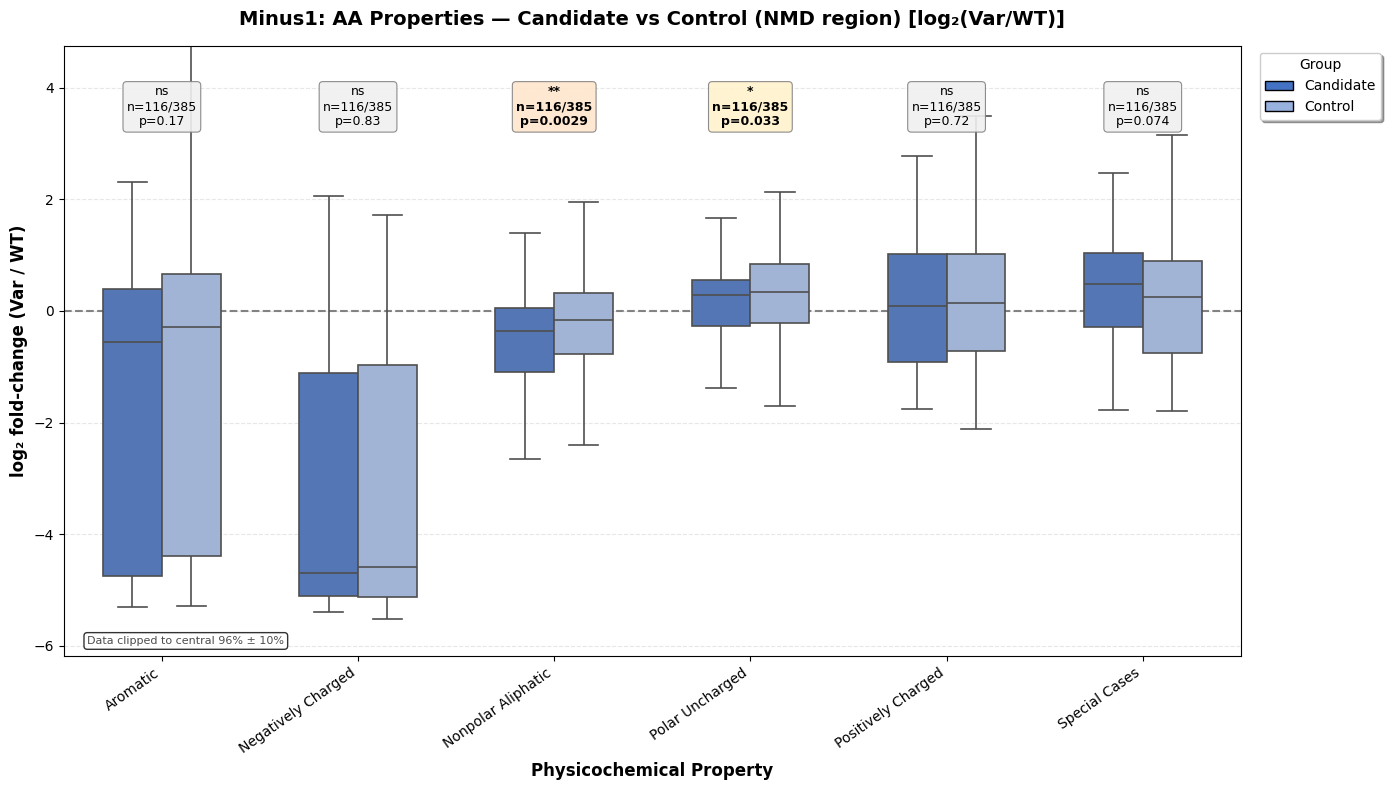

In [12]:
# Save as high-quality PNG
fig, ax = plot_properties_central(
    df_NMD_unique, props_nmd,context_label="NMD region",
    category="Minus1",
    q=(0.02, 0.98),
    pad=0.1,
    stats_headroom=0.2,
    savepath="minus1_aa_properties_data_clipped.png"  # Will save as 300 DPI PNG
)

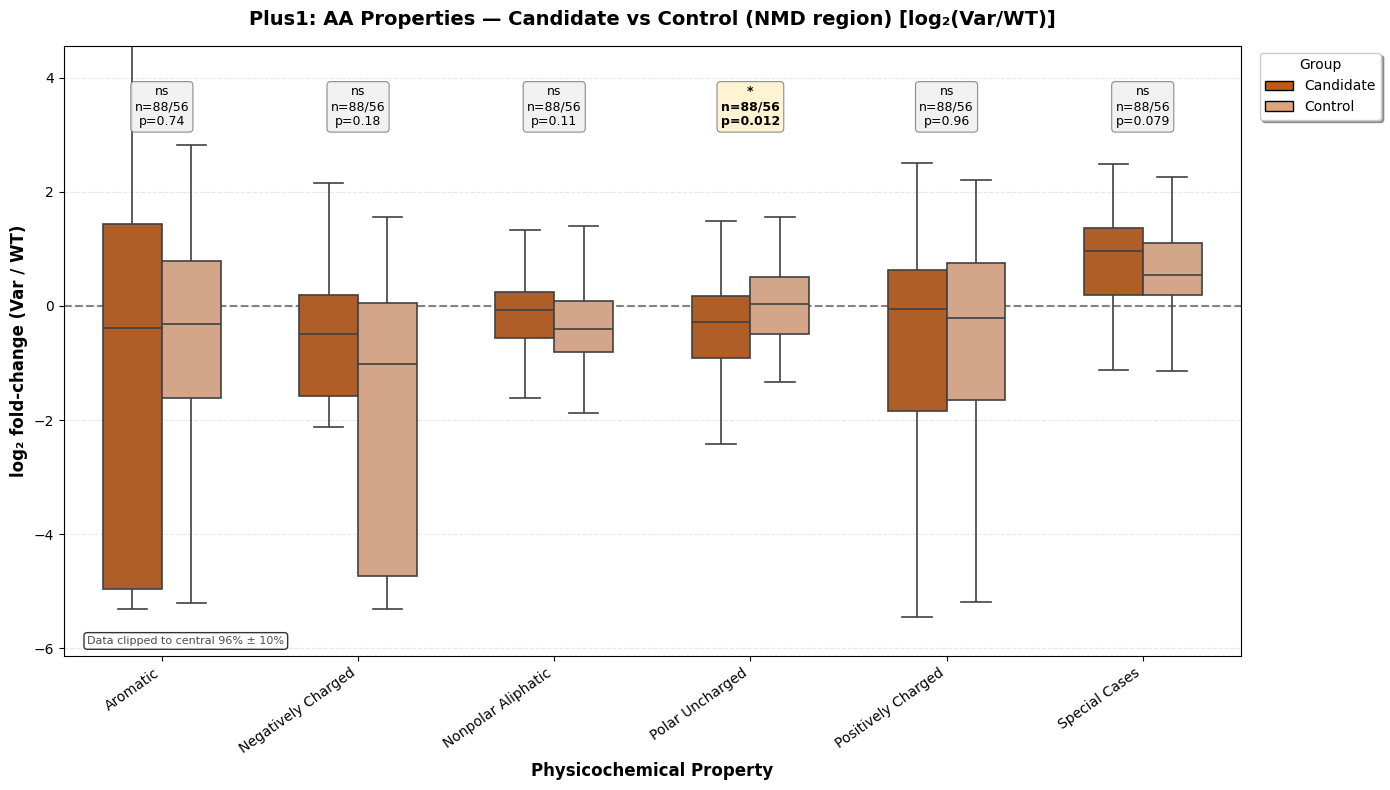

In [13]:
# Save as high-quality PNG
fig, ax = plot_properties_central(
    df_NMD_unique, props_nmd,context_label="NMD region",
    category="Plus1",
    q=(0.02, 0.98),
    pad=0.1,
    stats_headroom=0.2,
    savepath="plus1_aa_properties_data_clipped.png"  # Will save as 300 DPI PNG
)

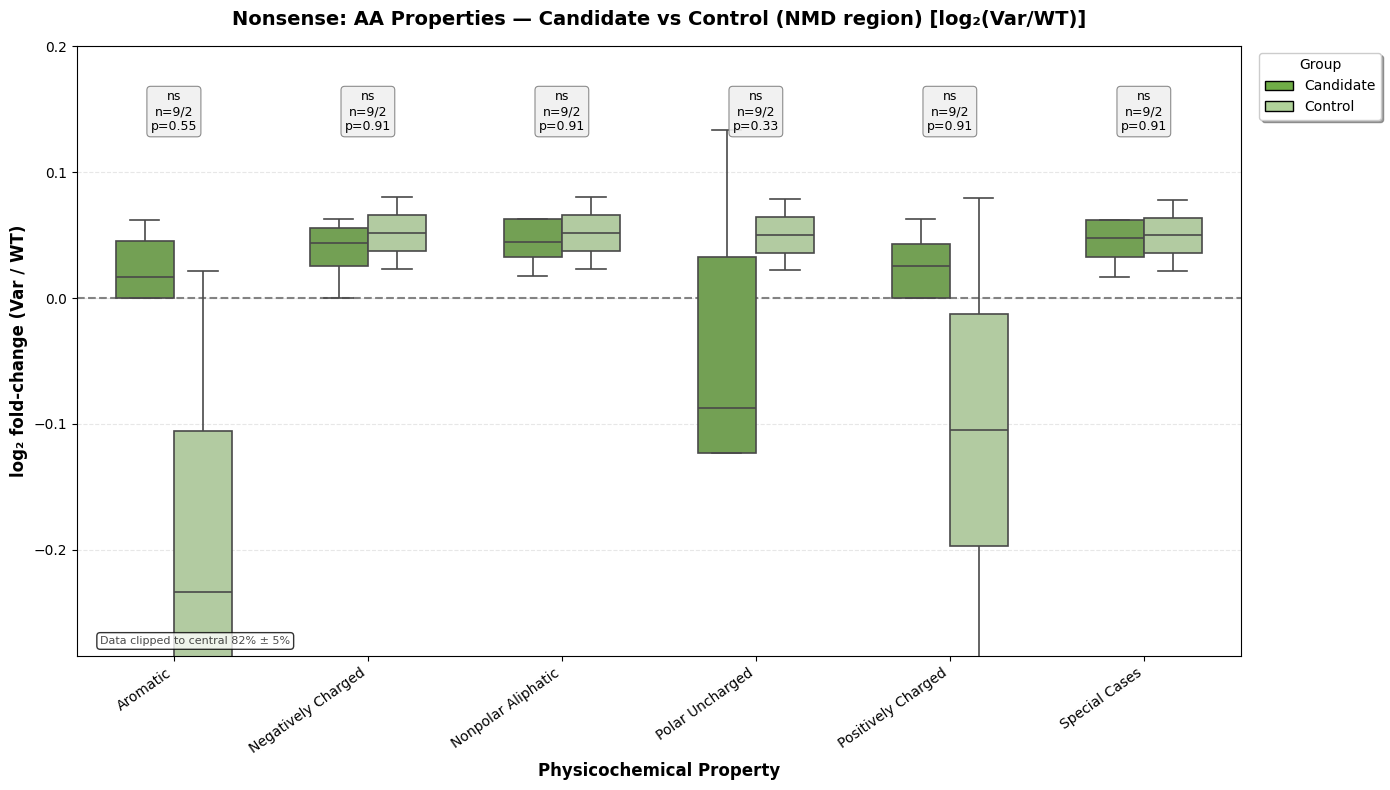

In [14]:
fig, ax = plot_properties_central(
    df_NMD_unique, props_nmd,
    category="Nonsense",context_label="NMD region",
    q=(0.08, 0.90),  # Changed from (0.10, 0.90) - more room below
    pad=0.05,
    stats_headroom=0.2,
    savepath="nonsense_aa_properties_data_clipped.png"
)

In [15]:
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")

def build_aa_colmap_fl(df):
    """
    Returns {'WT': {AA: colname}, 'Var': {AA: colname}} for Full Length.
    Supports columns like:
      aa_X_WT_FL, aa_X_var_FL, aa_AA_X_WT_FL, aa_AA_X_vars_FL, and
      versions without the _FL suffix if present.
    Ignores Diff columns.
    """
    WT, VAR = {}, {}

    for c in df.columns:
        if "Diff" in c:   # ignore difference columns
            continue

        # Try compact FL pattern: aa_X_WT_FL, aa_X_var_FL
        m = re.match(r"^aa_([A-Z])_(WT|var|vars)(?:_FL|_fl)?$", c)
        if not m:
            # Try the AA-prefixed pattern: aa_AA_X_WT_FL, aa_AA_X_vars_FL
            m = re.match(r"^aa_AA_([A-Z])_(WT|var|vars)(?:_FL|_fl)?$", c)
        if not m:
            continue

        aa, kind = m.groups()
        if aa not in AA_LIST:
            continue

        if kind.upper() == "WT":
            WT[aa] = c
        else:
            VAR[aa] = c

    # Report what we found
    print(f"Found WT AAs ({len(WT)}): {sorted(WT.keys())}")
    print(f"Found Var AAs ({len(VAR)}): {sorted(VAR.keys())}")

    return {"WT": WT, "Var": VAR}

# example:
aa_map_fl = build_aa_colmap_fl(df_collapsed)

Found WT AAs (20): ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Found Var AAs (20): ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


In [16]:
# --- 2) Add property-level log2FC for Full Length (NaN -> 0 treated as absence) ---

AA_GROUPS = {
    "Aromatic":             list("FWY"),
    "Negatively_Charged":   list("DE"),
    "Nonpolar_Aliphatic":   list("AVLIM"),
    "Polar_Uncharged":      list("STNQ"),
    "Positively_Charged":   list("KRH"),
    "Special_Cases":        list("CGP"),
}

def add_property_log2fc_FL(df, aa_map, epsilon_pp=1e-6):
    """
    Creates <Property>_log2FC_FL columns:
        log2( (sum Var AAs + eps) / (sum WT AAs + eps) )
    NaNs in per-AA inputs are filled with 0 (absence).
    """
    for prop, aas in AA_GROUPS.items():
        wt_cols  = [aa_map["WT"][a]  for a in aas if a in aa_map["WT"]]
        var_cols = [aa_map["Var"][a] for a in aas if a in aa_map["Var"]]

        if not wt_cols or not var_cols:
            print(f"[warn] Skipping {prop}: missing one or more AA columns in WT or Var.")
            continue

        WT  = df[wt_cols].fillna(0).sum(axis=1).astype(float)
        VAR = df[var_cols].fillna(0).sum(axis=1).astype(float)

        df[f"{prop}_log2FC_FL"] = np.log2((VAR + epsilon_pp) / (WT + epsilon_pp))

    return df

df_collapsed = add_property_log2fc_FL(df_collapsed, aa_map_fl, epsilon_pp=1e-6)

# sanity: check we created the columns
[col for col in df_collapsed.columns if col.endswith("_log2FC_FL")]

['Aromatic_log2FC_FL',
 'Negatively_Charged_log2FC_FL',
 'Nonpolar_Aliphatic_log2FC_FL',
 'Polar_Uncharged_log2FC_FL',
 'Positively_Charged_log2FC_FL',
 'Special_Cases_log2FC_FL']

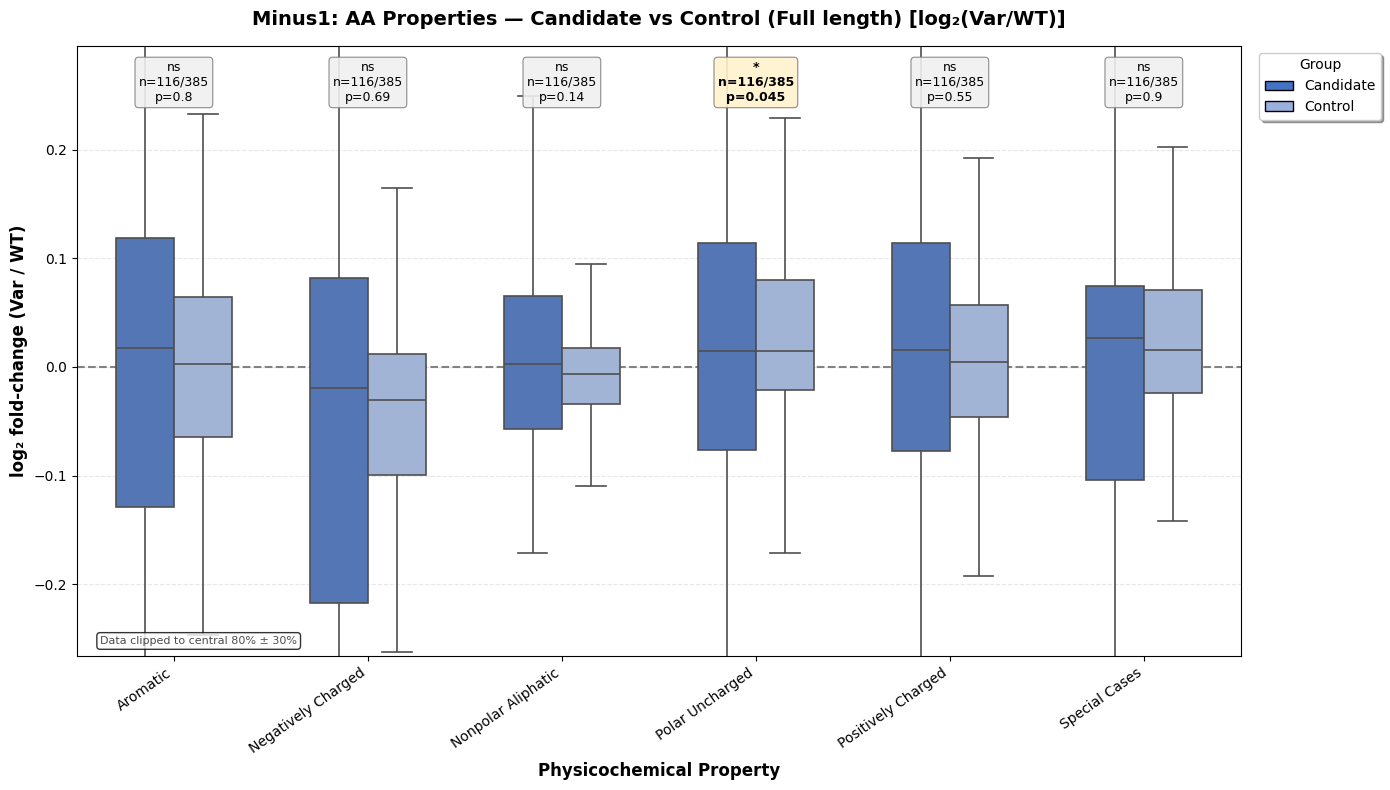

In [17]:
# --- 3) Plot Full Length with your central-window function ---
props_fl = [
    "Aromatic_log2FC_FL",
    "Negatively_Charged_log2FC_FL",
    "Nonpolar_Aliphatic_log2FC_FL",
    "Polar_Uncharged_log2FC_FL",
    "Positively_Charged_log2FC_FL",
    "Special_Cases_log2FC_FL",
]

fig, ax = plot_properties_central(
    df=df_collapsed,
    prop_cols=props_fl,
    category="Minus1",            # or "Plus1", "Nonsense"
    context_label="Full length",
    metric="log2fc",
    q=(0.10, 0.90),
    pad=0.3,
    hide_fliers=True,
    clip_whiskers=True,
    savepath="full_minus1_aa_properties_data_clipped.png"
)

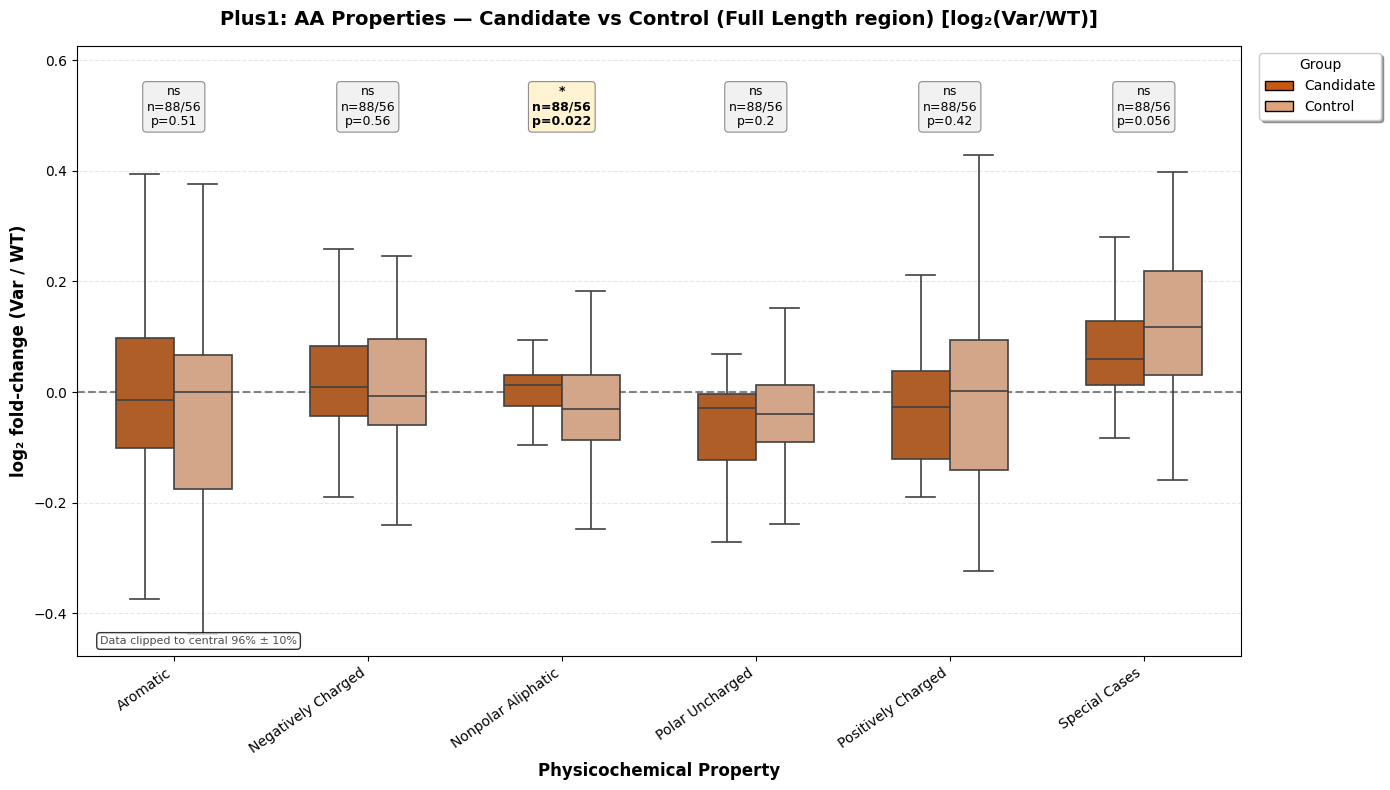

In [18]:
fig, ax = plot_properties_central(
    df_collapsed, props_fl,
    category="Plus1",
    context_label="Full Length region",  # Custom label
    q=(0.02, 0.98),
    pad=0.1,
    stats_headroom=0.2,savepath="full_plus1_aa_properties_data_clipped.png"
)

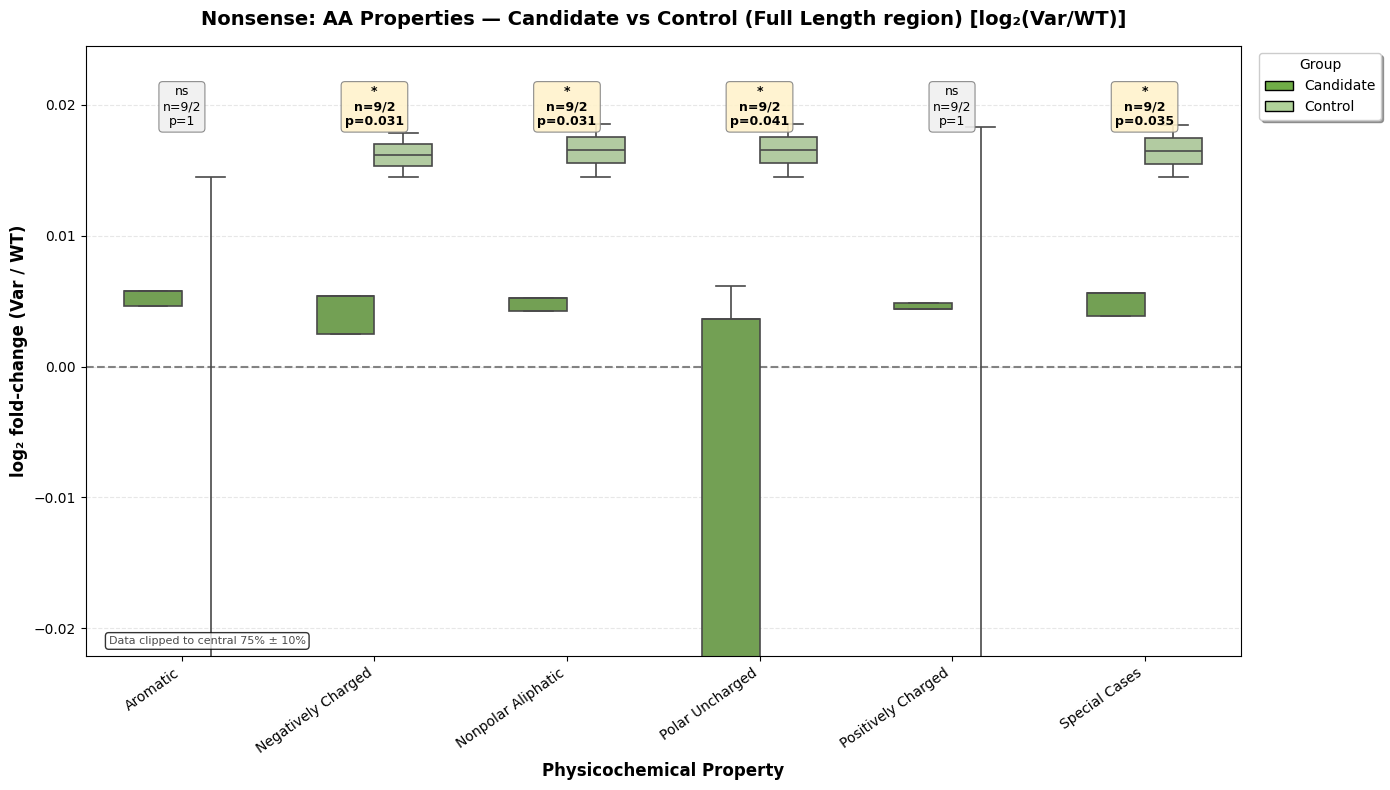

In [19]:
fig, ax = plot_properties_central(
    df_collapsed, props_fl,
    category="Nonsense",
    context_label="Full Length region",  # Custom label
    q=(0.15, 0.9),  # Changed from (0.10, 0.90) - more room below
    pad=0.10,
    stats_headroom=0.2,savepath="full_nonsense_aa_properties_data_clipped.png"
)

In [20]:
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")

def _detect_aa_cols(df, region="nmd"):
    """
    Detect per-AA WT/Var columns for the given region.
    Supports:
      - aa_AA_X_WT_nmd / aa_AA_X_vars_nmd
      - aa_X_WT_FL / aa_X_var_FL
    Ignores Diff columns. Case-insensitive.
    """
    WT, VAR = {}, {}
    region = (region or "").lower()
    # preferred region tokens
    want_nmd = {"nmd"}
    want_fl  = {"fl", "full", "full_length"}
    def score_tail(tail_l):
        if region == "nmd":
            return (any(tok in tail_l for tok in want_nmd), any(tok in tail_l for tok in want_fl))
        else:  # "fl"
            return (any(tok in tail_l for tok in want_fl), any(tok in tail_l for tok in want_nmd))

    for c in df.columns:
        cl = c.lower()
        if "diff" in cl:  # skip derived diffs as inputs
            continue

        m = re.match(r"^aa(?:_aa)?_([A-Z])_(WT|var|vars)(.*)$", c, flags=re.IGNORECASE)
        if not m:
            continue
        aa, kind, tail = m.groups()
        aa = aa.upper()
        kind = kind.lower()
        if aa not in AA_LIST:
            continue

        tail_l = tail.lower()
        sc = score_tail(tail_l)

        if kind == "wt":
            prev = WT.get(aa, ((False, False), None))
            if prev[1] is None or prev[0] < sc:
                WT[aa] = (sc, c)
        else:  # var/vars
            prev = VAR.get(aa, ((False, False), None))
            if prev[1] is None or prev[0] < sc:
                VAR[aa] = (sc, c)

    WT = {aa: tup[1] for aa, tup in WT.items() if tup[1] is not None}
    VAR = {aa: tup[1] for aa, tup in VAR.items() if tup[1] is not None}

    print(f"[detect] Found WT AAs ({len(WT)}): {sorted(WT.keys())}")
    print(f"[detect] Found Var AAs ({len(VAR)}): {sorted(VAR.keys())}")
    return {"WT": WT, "Var": VAR}

def add_aa_level_metrics(
    df,
    region="nmd",          # "nmd" or "fl"
    context_label=None,    # "NMD" or "FL" (auto if None)
    epsilon_pp=0.1,        # absolute floor in percentage points
    smooth_alpha=0.02,     # proportional floor (fraction of WT)
    keep_ratio=False,      # optionally store X_ratio_<region>
    overwrite=True
):
    """
    Creates for each AA X:
      X_Diff_<CTX>   = Var - WT   (percent composition)
      X_log2FC_<CTX> = log2( (Var + α·WT + ε) / (WT + α·WT + ε) )
    NaNs in inputs are treated as 0 (absence). Handles both NMD and Full Length schemas.
    """
    region = region.lower()
    if context_label is None:
        context_label = "NMD" if region == "nmd" else "FL"

    aa_map = _detect_aa_cols(df, region=region)

    missing = []
    for aa in AA_LIST:
        wt_col  = aa_map["WT"].get(aa)
        var_col = aa_map["Var"].get(aa)
        if not wt_col or not var_col:
            missing.append(aa)
            continue

        diff_col  = f"{aa}_Diff_{context_label}"
        ratio_col = f"{aa}_ratio_{region}"
        l2fc_col  = f"{aa}_log2FC_{context_label}"

        if (not overwrite) and all(c in df.columns for c in ([diff_col, l2fc_col] + ([ratio_col] if keep_ratio else []))):
            continue

        WT  = df[wt_col].astype(float).fillna(0.0)
        VAR = df[var_col].astype(float).fillna(0.0)

        # difference in % composition
        df[diff_col] = VAR - WT

        # smoothed ratio & log2FC
        WT_s  = WT  + smooth_alpha*WT  + epsilon_pp
        VAR_s = VAR + smooth_alpha*WT  + epsilon_pp
        ratio = VAR_s / WT_s
        if keep_ratio:
            df[ratio_col] = ratio
        df[l2fc_col] = np.log2(ratio)

    if missing:
        print(f"[warn] Skipped AAs with missing WT/Var columns: {missing}")

    return df


In [21]:
df_NMD_unique = add_aa_level_metrics(
    df_NMD_unique, region="nmd", context_label="NMD",
    epsilon_pp=0.1, smooth_alpha=0.02, keep_ratio=False
)

aa_log2_nmd = [f"{aa}_log2FC_NMD" for aa in AA_LIST if f"{aa}_log2FC_NMD" in df_NMD_unique.columns]
# plot as before:
# plot_properties_central(df_NMD_unique, aa_log2_nmd, category="Minus1", context_label="NMD region", metric="log2fc", ...)

[detect] Found WT AAs (20): ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
[detect] Found Var AAs (20): ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


In [22]:
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")

def lighten_color(color, amount=0.55):
    r, g, b = mcolors.to_rgb(color)
    return (1 - amount) + amount*r, (1 - amount) + amount*g, (1 - amount) + amount*b

def _parse_aa_label(col):
    """
    Robustly extract the AA letter from common column names:
      'A_log2FC_NMD', 'A_Diff_FL', 'aa_AA_A_log2FC_NMD', etc.
    """
    m = re.search(r'aa_AA_([A-Z])_', col)
    if m: return m.group(1)
    m = re.match(r'^([A-Z])_', col)
    if m: return m.group(1)
    # fallback: last capital letter token
    m = re.findall(r'[A-Z]', col)
    return m[0] if m else col

def _add_sig_stars_clear(
    ax, melted, order_x,
    show_ns=False,
    y_quantile=None,        # None => use max; else use this quantile (e.g., 0.99)
    pad_frac=0.05,          # gap above data (fraction of axis span)
    top_extra=0.06,         # extra headroom above highest star
    fontsize=13, color="black"
):


    ylo, yhi = ax.get_ylim()
    yspan = (yhi - ylo) if yhi > ylo else 1.0
    pad = pad_frac * yspan
    bump = top_extra * yspan
    new_top = yhi

    for i, label in enumerate(order_x):
        sub = melted[melted["AA"] == label]
        a = sub.loc[sub["status"]=="Candidate","value"].dropna().to_numpy()
        b = sub.loc[sub["status"]=="Control","value"].dropna().to_numpy()
        if not (a.size and b.size):
            continue

        p = mannwhitneyu(a, b, alternative="two-sided").pvalue
        s = stars(p)
        if (s == "ns") and not show_ns:
            continue

        y_base = (np.nanquantile(sub["value"], y_quantile)
                  if y_quantile is not None else np.nanmax(sub["value"]))
        y_star = y_base + pad
        new_top = max(new_top, y_star + bump)

        txt = ax.text(i, y_star, s, ha="center", va="bottom",
                      fontsize=fontsize, fontweight="bold", color=color, zorder=10)
        # white halo so stars stand out from outlier dots
        txt.set_path_effects([pe.withStroke(linewidth=3, foreground="white")])

    if new_top > yhi:
        ax.set_ylim(ylo, new_top)

def add_clip_note(ax, values, q=None, pad=None, *, loc=(0.015, 0.035)):
    """
    Add a small 'Data clipped…' note in the bottom-left of the axes.
    - values: 1D array/Series of the plotted y-values (with NaNs allowed)
    - q: tuple like (0.1, 0.9) used for zooming; if None, do nothing
    - pad: the padding you applied around the quantile window (same units as data)
    - loc: axes coords (x,y) for the note (0..1)
    """
    if q is None:  # only show when we actually zoomed
        return
    v = pd.Series(values).dropna()
    if v.empty:
        return

    qlo, qhi = v.quantile(q)
    central_pct = (q[1] - q[0]) * 100

    # Express pad as a % of the quantile window height (so it reads like '±10%')
    pad_pct = None
    if pad is not None and (qhi - qlo) > 0:
        pad_pct = 100 * pad / (qhi - qlo)

    note = f"Data clipped to central {central_pct:.0f}%"
    if pad_pct is not None:
        note += f" ± {pad_pct:.0f}%"

    ax.text(
        loc[0], loc[1], note,
        transform=ax.transAxes, ha="left", va="bottom", fontsize=9, color="0.25",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9)
    )

def stars(p): return "ns" if p>=0.05 else ("*" if p<0.05 and p>=0.01 else ("**" if p<0.01 and p>=0.001 else "***"))

def plot_aa_panel(
    df,
    aa_cols,                        # e.g. ["A_log2FC_NMD", "C_log2FC_NMD", ...]
    category="Minus1",              # "Minus1" | "Plus1" | "Nonsense"
    context_label="NMD region",
    metric="log2fc",                # "log2fc" or "diff" (labels/baseline only)
    savepath=None,
    order_aa=None,                  # list of AAs in the order you want on x-axis
    # appearance / zoom
    figsize=(16, 7),
    hide_fliers=True,
    ylim=None,                      # e.g. (-2, 2). If None, optional quantile zoom used.
    q=None, pad=0.25,               # e.g. q=(0.1, 0.9) + pad for central zoom
    clip_whiskers=True,
    # stars
    show_ns=False,
    star_quantile=None,             # None => max; else e.g. 0.99
    star_pad_frac=0.05,
    star_top_extra=0.06,
    star_fontsize=13
):
    # ---------- tidy to long ----------
    long = df[aa_cols + ["source"]].copy()

    g = long["source"].astype(str)
    g = (g.str.replace("snv_control","Nonsense_Control",case=False,regex=False)
           .str.replace("snv","Nonsense",case=False,regex=False)
           .str.replace("minus1_control","Minus1_Control",case=False,regex=False)
           .str.replace("plus1_control","Plus1_Control",case=False,regex=False)
           .str.replace("minus1","Minus1",case=False,regex=False)
           .str.replace("plus1","Plus1",case=False,regex=False))
    long["group"]  = g
    long["family"] = long["group"].str.replace("_Control","",regex=False)
    long["status"] = np.where(long["group"].str.endswith("_Control"), "Control", "Candidate")

    long = long[long["family"] == category]
    if long.empty:
        raise ValueError(f"No rows for category={category}")

    melted = long.melt(id_vars=["group","family","status","source"],
                       var_name="aa_col", value_name="value")
    melted["AA"] = melted["aa_col"].map(_parse_aa_label)
    melted["value"] = pd.to_numeric(melted["value"], errors="coerce")

    # keep AAs that have any data
    good = melted.groupby("AA")["value"].apply(lambda s: s.notna().any())
    melted = melted[melted["AA"].isin(good[good].index)]

    # x order
    if order_aa is None:
        # keep canonical AA order where present
        present = [aa for aa in AA_LIST if aa in melted["AA"].unique()]
        order_aa = present
    else:
        # ensure they exist
        order_aa = [aa for aa in order_aa if aa in melted["AA"].unique()]

    # ---------- plot ----------
    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(True, axis="y", alpha=0.3, linestyle="--"); ax.set_axisbelow(True)

    base = FAMILY_COLOR.get(category, "#777")
    pal = {"Candidate": base, "Control": lighten_color(base)}

    sns.boxplot(
        data=melted, x="AA", y="value",
        hue="status", hue_order=["Candidate","Control"],
        order=order_aa, palette=pal, width=0.6, dodge=True, ax=ax,
        legend=False, fliersize=0 if hide_fliers else 3, linewidth=1.0
    )

    # zoom handling
    if ylim is not None:
        ax.set_ylim(*ylim)
    elif q is not None:
        qlo, qhi = melted["value"].quantile(q)
        ax.set_ylim(qlo - pad, qhi + pad)
        add_clip_note(ax, melted["value"], q=q, pad=pad)


    # clip whiskers/outliers to axes if requested
    if clip_whiskers:
        for artist in (ax.lines + ax.artists + ax.collections):
            try:
                artist.set_clip_on(True)
                artist.set_clip_path(ax.patch)
            except Exception:
                pass

    # labels/titles
    ax.set_xlabel("Amino Acid", fontsize=12, fontweight="bold")
    ylabel = "log₂ fold-change (Var / WT)" if metric.lower()=="log2fc" \
             else "Δ AA composition (Var − WT, %)"
    ax.set_ylabel(ylabel, fontsize=12, fontweight="bold")
    title_metric = "[log₂(Var/WT)]" if metric.lower()=="log2fc" else "[Var − WT]"
    ax.set_title(f"{category}: AA Properties — Candidate vs Control ({context_label}) {title_metric}",
                 fontsize=16, fontweight="bold", pad=6)

    if metric.lower() == "log2fc":
        ax.axhline(0, ls="--", lw=1, color="0.35", zorder=0)

    # ticks
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

    # legend
    handles = [Patch(facecolor=pal["Candidate"], edgecolor="k", label="Candidate"),
               Patch(facecolor=pal["Control"],   edgecolor="k", label="Control")]
    ax.legend(handles=handles, title="Group", loc="upper left", bbox_to_anchor=(1.01, 1.0))

    # significance stars (clear, top-anchored)
    _add_sig_stars_clear(
        ax=ax, melted=melted, order_x=order_aa,
        show_ns=show_ns, y_quantile=star_quantile,
        pad_frac=star_pad_frac, top_extra=star_top_extra,
        fontsize=star_fontsize, color="black"
    )

    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    return fig, ax


(<Figure size 1600x700 with 1 Axes>,
 <Axes: title={'center': 'Minus1: AA Properties — Candidate vs Control (NMD region) [log₂(Var/WT)]'}, xlabel='Amino Acid', ylabel='log₂ fold-change (Var / WT)'>)

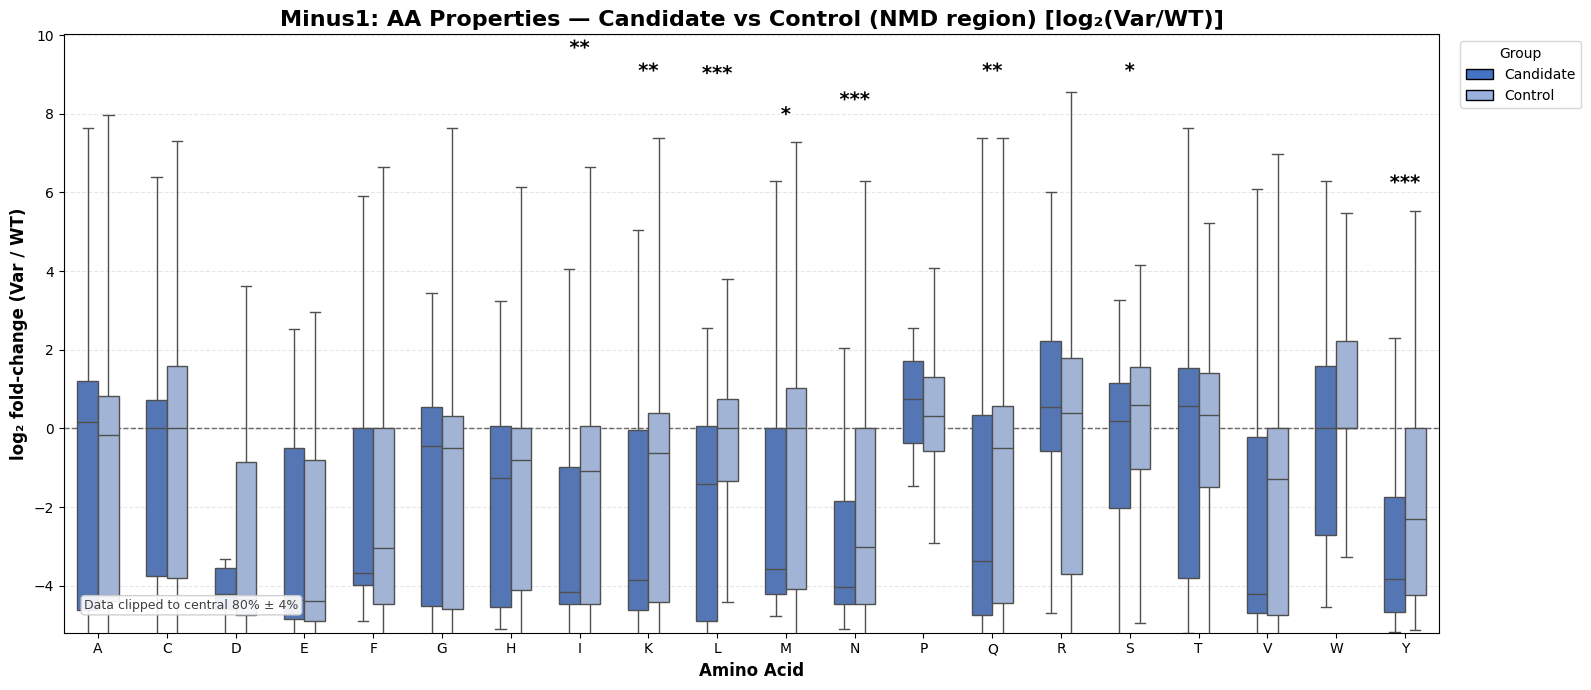

In [23]:
# NMD, log2FC, all 20 AAs (if columns exist)
aa_log2_nmd = [f"{aa}_log2FC_NMD" for aa in AA_LIST if f"{aa}_log2FC_NMD" in df_NMD_unique.columns]

plot_aa_panel(
    df_NMD_unique, aa_log2_nmd,
    category="Minus1", context_label="NMD region",
    metric="log2fc",
    ylim=None, q=(0.10, 0.90), pad=0.3,     # or set a fixed ylim like (-2,2)
    hide_fliers=True, clip_whiskers=True,
    show_ns=False,                           # hide ns
    star_quantile=None,                      # anchor at max
    star_pad_frac=0.06, star_top_extra=0.08, star_fontsize=14,
    savepath="Minus1_AA_log2fc_NMD_stars.png"
)


(<Figure size 1600x700 with 1 Axes>,
 <Axes: title={'center': 'Minus1: AA Properties — Candidate vs Control (NMD region) [log₂(Var/WT)]'}, xlabel='Amino Acid', ylabel='log₂ fold-change (Var / WT)'>)

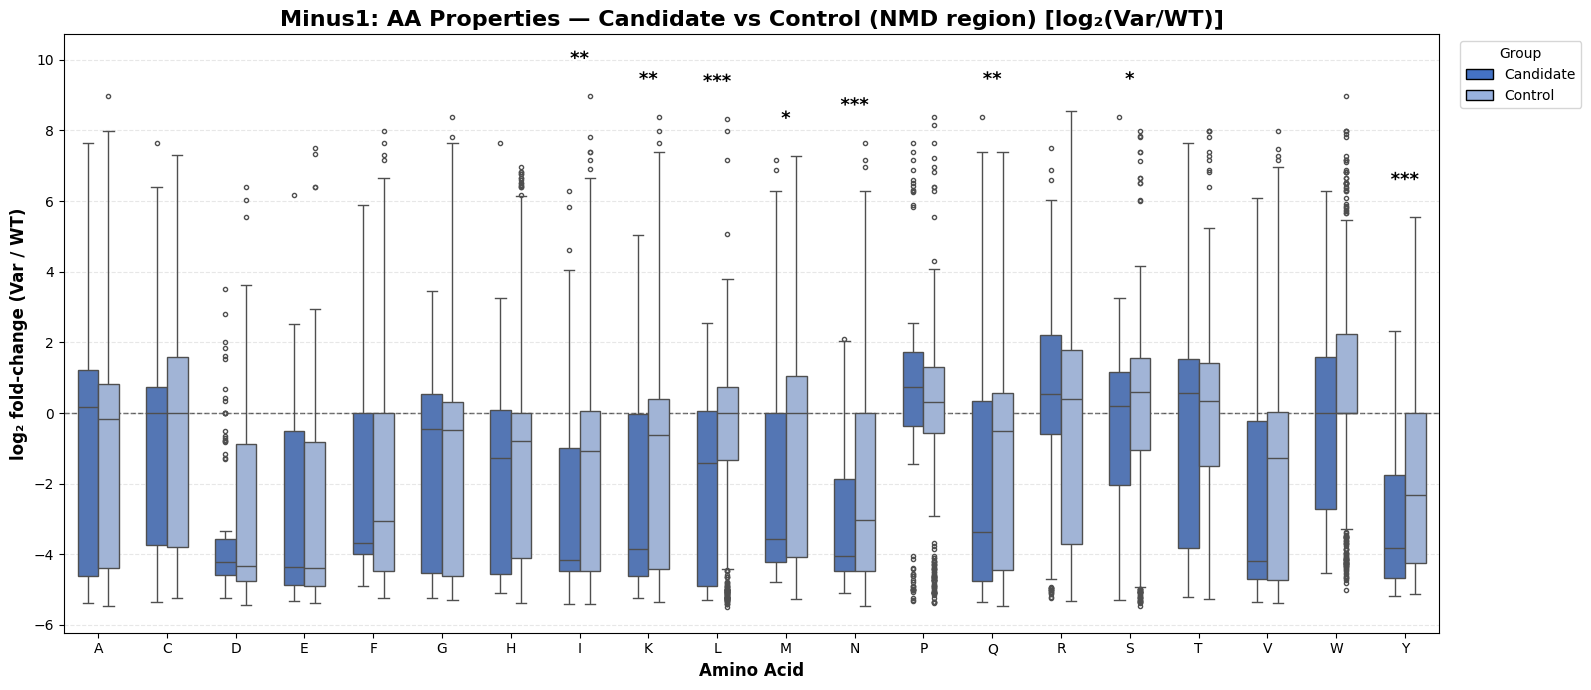

In [24]:
plot_aa_panel(
    df_NMD_unique, aa_log2_nmd,
    category="Minus1", context_label="NMD region",
    metric="log2fc",
    # --- no zoom: let the axis autoscale to ALL data ---
    ylim=None,
    q=None,            # disables quantile zoom
    # show everything (including outliers)
    hide_fliers=False,
    clip_whiskers=False,
    show_ns=False,
    star_quantile=None,  # stars anchored at the true max
    savepath="Minus1_individualaa_log2fc_NMD.png"
)

(<Figure size 1600x700 with 1 Axes>,
 <Axes: title={'center': 'Plus1: AA Properties — Candidate vs Control (NMD region) [log₂(Var/WT)]'}, xlabel='Amino Acid', ylabel='log₂ fold-change (Var / WT)'>)

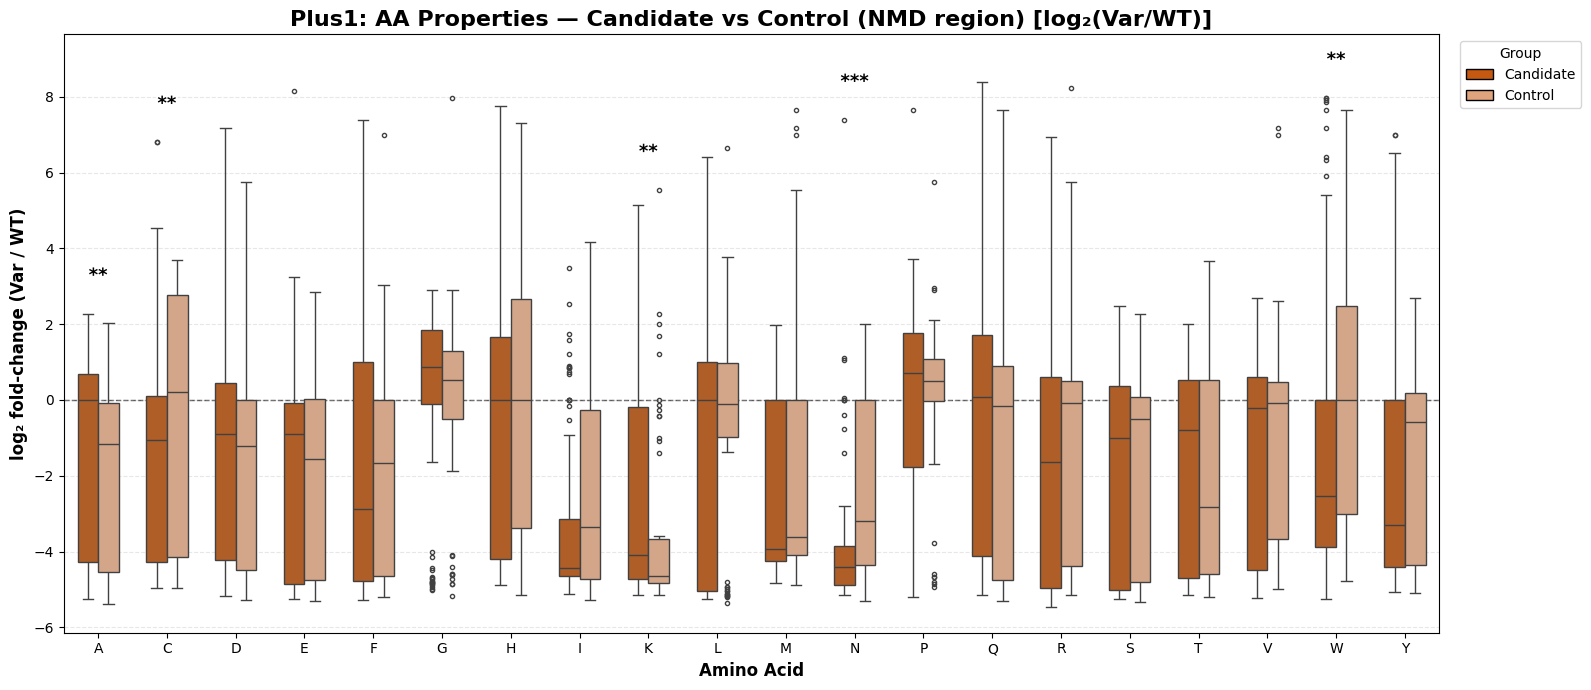

In [25]:
plot_aa_panel(
    df_NMD_unique, aa_log2_nmd,
    category="Plus1", context_label="NMD region",
    metric="log2fc",
    # --- no zoom: let the axis autoscale to ALL data ---
    ylim=None,
    q=None,            # disables quantile zoom
    # show everything (including outliers)
    hide_fliers=False,
    clip_whiskers=False,
    show_ns=False,
    star_quantile=None,  # stars anchored at the true max
    savepath="Plus1_individualaa_log2fc_NMD.png"
)

(<Figure size 1600x700 with 1 Axes>,
 <Axes: title={'center': 'Nonsense: AA Properties — Candidate vs Control (NMD region) [log₂(Var/WT)]'}, xlabel='Amino Acid', ylabel='log₂ fold-change (Var / WT)'>)

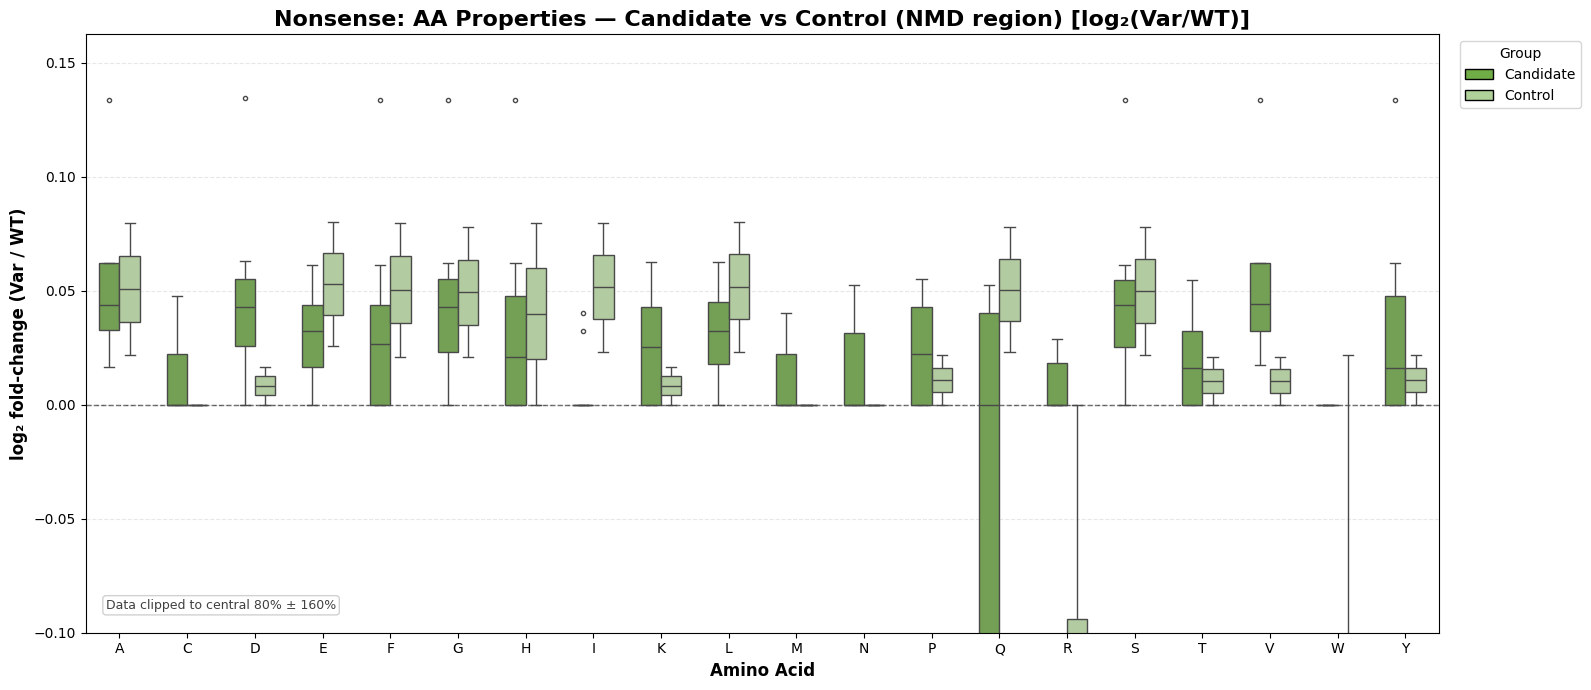

In [26]:
plot_aa_panel(
    df_NMD_unique, aa_log2_nmd,
    category="Nonsense", context_label="NMD region",
    metric="log2fc",
    # --- no zoom: let the axis autoscale to ALL data ---
    ylim=None,
    q=(0.10, 0.90), pad=0.1,
    hide_fliers=False,
    clip_whiskers=False,
    show_ns=False,
    star_quantile=None,  # stars anchored at the true max
    savepath="Nonsense_individualaa_log2fc_NMD.png"
)

(<Figure size 1600x700 with 1 Axes>,
 <Axes: title={'center': 'Nonsense: AA Properties — Candidate vs Control (NMD region) [log₂(Var/WT)]'}, xlabel='Amino Acid', ylabel='log₂ fold-change (Var / WT)'>)

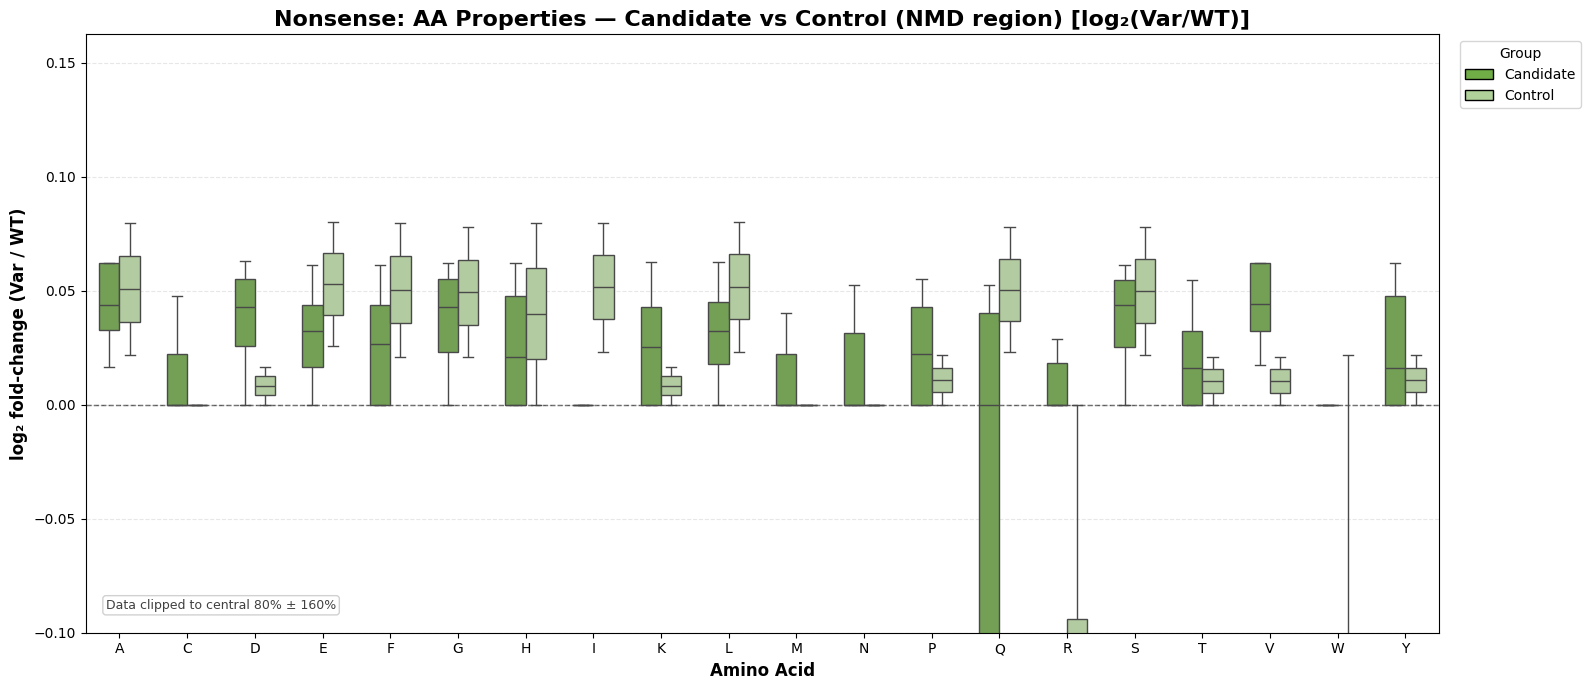

In [27]:
plot_aa_panel(
    df_NMD_unique, aa_log2_nmd,
    category="Nonsense", context_label="NMD region",
    metric="log2fc",
    ylim=None,                 # don't set fixed limits
    q=(0.10, 0.90), pad=0.10,  # zoom to central 80% + padding
    hide_fliers=True,          # optional, cleaner when zooming
    clip_whiskers=True,
    show_ns=False,
    # anchor stars to the top quantile so they stay inside the zoom
    star_quantile=0.90,        # or 0.95
    star_pad_frac=0.06,
    star_top_extra=0.08,
    savepath="Nonsense_individualaa_log2fc_NMD_zoom.png"
)

In [28]:
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")

def add_aa_log2fc_full_length(
    df,
    eps=0.1,           # small constant in % points
    alpha=0.02         # 2% of WT (stabilizes tiny baselines)
):
    """
    Add per-AA log2(Var/WT) columns for Full Length.
    Expects columns like 'aa_A_WT_FL' and 'aa_A_var_FL'.
    Returns the list of new columns that were created.
    """
    new_cols = []
    for aa in AA_LIST:
        # try the common names you showed
        wt_candidates  = [f"aa_{aa}_WT_FL",  f"aa_AA_{aa}_WT_FL",  f"{aa}_WT_FL"]
        var_candidates = [f"aa_{aa}_var_FL", f"aa_AA_{aa}_var_FL", f"{aa}_var_FL"]

        wt_col  = next((c for c in wt_candidates  if c in df.columns), None)
        var_col = next((c for c in var_candidates if c in df.columns), None)
        if wt_col is None or var_col is None:
            continue  # skip AAs that aren't present

        WT  = pd.to_numeric(df[wt_col],  errors="coerce").fillna(0.0)
        VAR = pd.to_numeric(df[var_col], errors="coerce").fillna(0.0)

        # smoothed ratio
        WT_s  = WT  + alpha*WT + eps
        VAR_s = VAR + alpha*WT + eps
        log2fc = np.log2(VAR_s / WT_s)

        out_col = f"{aa}_log2FC_FL"
        df[out_col] = log2fc
        new_cols.append(out_col)

    return new_cols

# run it
aa_log2_fl = add_aa_log2fc_full_length(df_collapsed)
print(f"Added {len(aa_log2_fl)} FL columns:", aa_log2_fl[:6], "...")

Added 20 FL columns: ['A_log2FC_FL', 'C_log2FC_FL', 'D_log2FC_FL', 'E_log2FC_FL', 'F_log2FC_FL', 'G_log2FC_FL'] ...


(<Figure size 1600x700 with 1 Axes>,
 <Axes: title={'center': 'Minus1: AA Properties — Candidate vs Control (Full Length region) [log₂(Var/WT)]'}, xlabel='Amino Acid', ylabel='log₂ fold-change (Var / WT)'>)

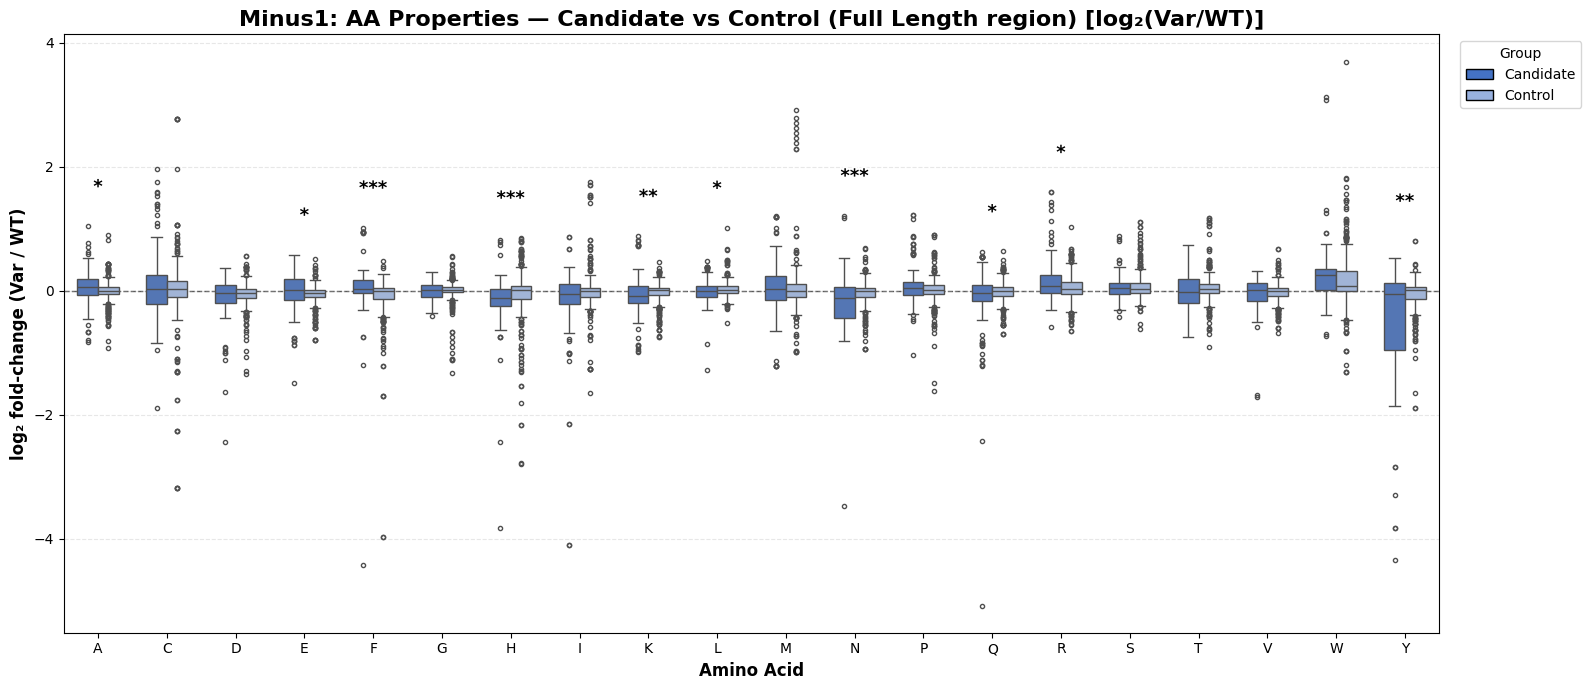

In [29]:
plot_aa_panel(
    df_collapsed, aa_log2_fl,
    category="Minus1", context_label="Full Length region",
    metric="log2fc",
    q=None, ylim=None,          # <- disables zoom
    hide_fliers=False, clip_whiskers=False,
    show_ns=False,
    star_quantile=None,         # stars anchored at true max
    savepath="Minus1_individualaa_log2fc_FL.png"
)

(<Figure size 1600x700 with 1 Axes>,
 <Axes: title={'center': 'Plus1: AA Properties — Candidate vs Control (Full Length region) [log₂(Var/WT)]'}, xlabel='Amino Acid', ylabel='log₂ fold-change (Var / WT)'>)

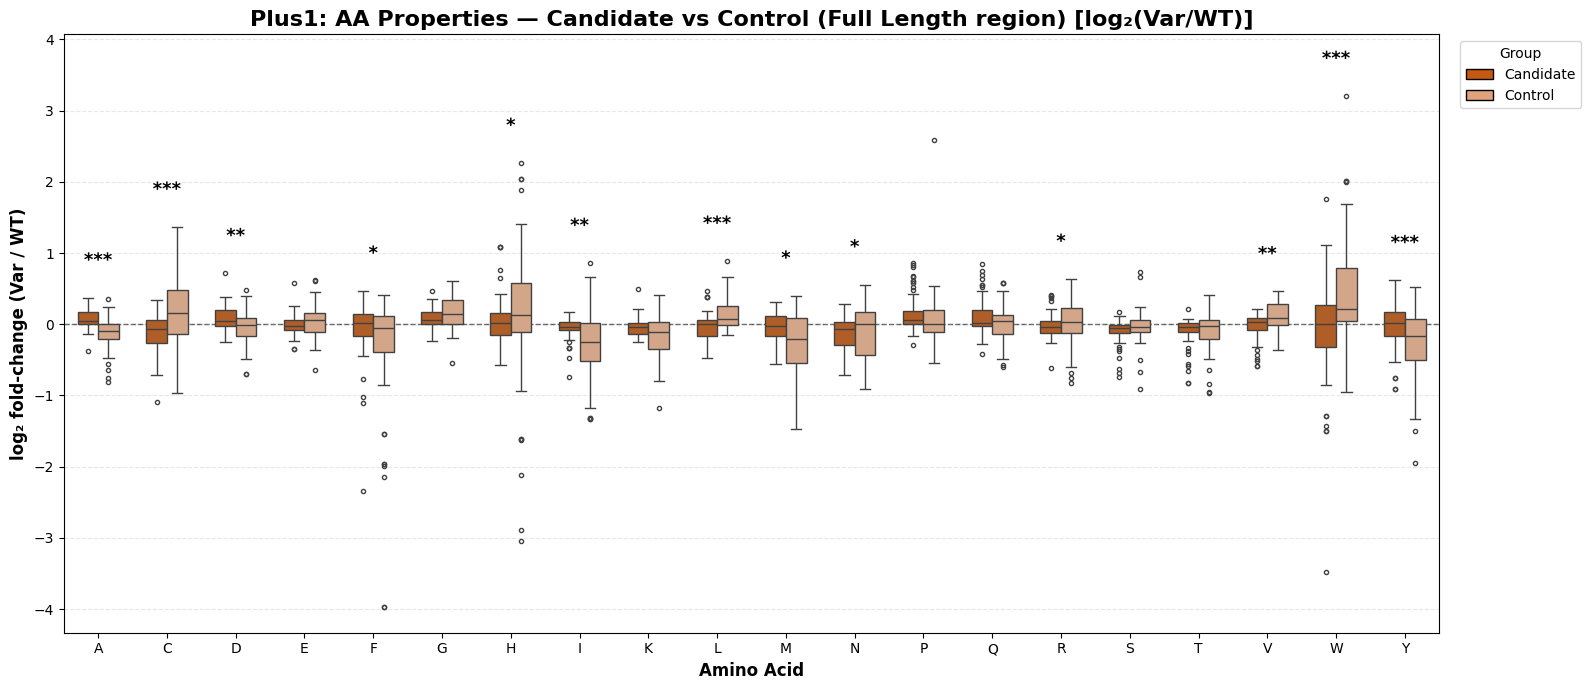

In [30]:
plot_aa_panel(
    df_collapsed, aa_log2_fl,
    category="Plus1", context_label="Full Length region",
    metric="log2fc",
    q=None, ylim=None,          # <- disables zoom
    hide_fliers=False, clip_whiskers=False,
    show_ns=False,
    star_quantile=None,         # stars anchored at true max
    savepath="Plus1_individualaa_log2fc_FL.png"
)

(<Figure size 1600x700 with 1 Axes>,
 <Axes: title={'center': 'Nonsense: AA Properties — Candidate vs Control (Full Length region) [log₂(Var/WT)]'}, xlabel='Amino Acid', ylabel='log₂ fold-change (Var / WT)'>)

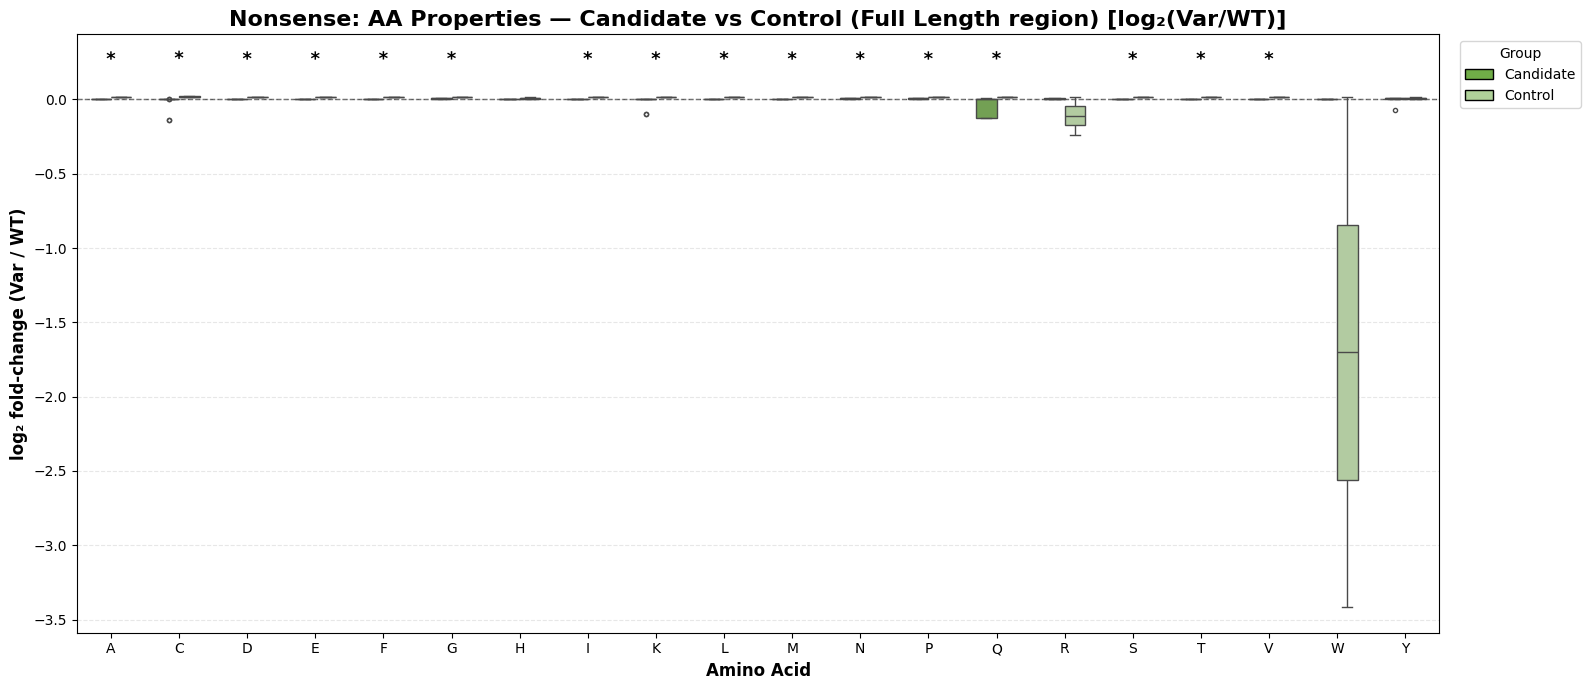

In [31]:
plot_aa_panel(
    df_collapsed, aa_log2_fl,
    category="Nonsense", context_label="Full Length region",
    metric="log2fc",
    q=None, ylim=None,          # <- disables zoom
    hide_fliers=False, clip_whiskers=False,
    show_ns=False,
    star_quantile=None,         # stars anchored at true max
    savepath="Nonsense_individualaa_log2fc_FL.png"
)